# Bước 1: Tải và khám phá bộ dữ liệu Online Retail

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

# Tải dữ liệu đã được làm sạch
df = pd.read_csv('../data/processed/cleaned_uk_data.csv')

# Hiển thị thông tin dữ liệu
print("=" * 50)
print("THÔNG TIN DỮ LIỆU ONLINE RETAIL")
print("=" * 50)
print(f"\nSố dòng: {df.shape[0]:,}")
print(f"Số cột: {df.shape[1]}")
print(f"\nCác cột: {list(df.columns)}")
print(f"\nSố khách hàng unique: {df['CustomerID'].nunique():,}")
print(f"Số sản phẩm unique: {df['StockCode'].nunique():,}")
print(f"Số hóa đơn unique: {df['InvoiceNo'].nunique():,}")

print("\n" + "=" * 50)
print("MẪU DỮ LIỆU")
print("=" * 50)
df.head()

THÔNG TIN DỮ LIỆU ONLINE RETAIL

Số dòng: 485,123
Số cột: 11

Các cột: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'TotalPrice', 'DayOfWeek', 'HourOfDay']

Số khách hàng unique: 3,921
Số sản phẩm unique: 3,916
Số hóa đơn unique: 18,021

MẪU DỮ LIỆU


C:\Users\nguye\AppData\Local\Temp\ipykernel_15024\3246348252.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/cleaned_uk_data.csv')


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DayOfWeek,HourOfDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,017850,United Kingdom,15.30,2,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,017850,United Kingdom,20.34,2,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,017850,United Kingdom,22.00,2,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,017850,United Kingdom,20.34,2,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,017850,United Kingdom,20.34,2,8


# Bước 2: Tạo đặc trưng RFM cho mỗi khách hàng

**RFM** là bộ 3 chỉ số kinh điển trong marketing:
- **R (Recency)**: Số ngày từ lần mua cuối cùng → Càng NHỎ càng tốt
- **F (Frequency)**: Số lần mua hàng (số hóa đơn) → Càng LỚN càng tốt
- **M (Monetary)**: Tổng số tiền đã chi → Càng LỚN càng tốt

In [2]:
# Chuyển đổi cột InvoiceDate sang datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Xác định ngày tham chiếu (ngày cuối cùng trong dataset + 1 ngày)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Ngày tham chiếu: {reference_date}")

# Tính RFM cho mỗi khách hàng
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency (số hóa đơn unique)
    'TotalPrice': 'sum'  # Monetary (tổng tiền)
}).reset_index()

# Đổi tên cột
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("\n" + "=" * 50)
print("BẢNG RFM CỦA KHÁCH HÀNG")
print("=" * 50)
print(f"\nSố khách hàng: {len(rfm):,}")
print(f"\nThống kê mô tả:")
print(rfm.describe())

print("\n" + "=" * 50)
print("MẪU DỮ LIỆU RFM")
print("=" * 50)
rfm.head(10)

Ngày tham chiếu: 2011-12-10 12:49:00

BẢNG RFM CỦA KHÁCH HÀNG

Số khách hàng: 3,921

Thống kê mô tả:
           Recency    Frequency      Monetary
count  3921.000000  3921.000000  3.921000e+03
mean     92.185157     4.596021  2.301765e+03
std      99.531817    23.013506  2.839137e+04
min       1.000000     1.000000  3.750000e+00
25%      18.000000     1.000000  3.003600e+02
50%      51.000000     2.000000  6.527400e+02
75%     143.000000     5.000000  1.578670e+03
max     374.000000  1373.000000  1.716831e+06

MẪU DỮ LIỆU RFM


,CustomerID,Recency,Frequency,Monetary
0,000nan,1,1373,1716830.53
1,012346,326,1,77183.60
2,012747,2,11,4196.01
3,012748,1,209,33719.73
4,012749,4,5,4090.88
5,012820,3,4,942.34
6,012821,214,1,92.72
7,012822,71,2,948.88
8,012823,75,5,1759.50
9,012824,60,1,397.12


# Bước 3: Chuẩn hóa dữ liệu (Standardization)

K-Means nhạy cảm với scale của dữ liệu, nên cần chuẩn hóa để các đặc trưng có cùng tầm quan trọng.

In [3]:
from sklearn.preprocessing import StandardScaler

# Lấy các đặc trưng RFM (bỏ CustomerID)
X = rfm[['Recency', 'Frequency', 'Monetary']].values

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Tạo DataFrame để dễ xem
X_scaled_df = pd.DataFrame(X_scaled, columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'])

print("=" * 50)
print("DỮ LIỆU SAU KHI CHUẨN HÓA")
print("=" * 50)
print(f"\nShape: {X_scaled.shape}")
print(f"\nMean của mỗi cột (gần 0):")
print(X_scaled.mean(axis=0))
print(f"\nStd của mỗi cột (gần 1):")
print(X_scaled.std(axis=0))

X_scaled_df.head()

DỮ LIỆU SAU KHI CHUẨN HÓA

Shape: (3921, 3)

Mean của mỗi cột (gần 0):
[ 5.02870720e-17 -3.62429347e-18  5.43644021e-18]

Std của mỗi cột (gần 1):
[1. 1. 1.]


,Recency_scaled,Frequency_scaled,Monetary_scaled
0,-0.916258,59.468493,60.396787
1,2.349446,-0.156277,2.637822
2,-0.906209,0.278306,0.066728
3,-0.916258,8.883047,1.106744
4,-0.886113,0.017556,0.063024


# Bước 4: Tìm số cụm K tối ưu bằng phương pháp Elbow

K = 1: Inertia = 11,763.00
K = 2: Inertia = 4,576.05
K = 3: Inertia = 1,444.38
K = 4: Inertia = 1,022.35
K = 5: Inertia = 752.84
K = 6: Inertia = 574.85
K = 7: Inertia = 478.38
K = 8: Inertia = 391.46
K = 9: Inertia = 307.67
K = 10: Inertia = 264.92


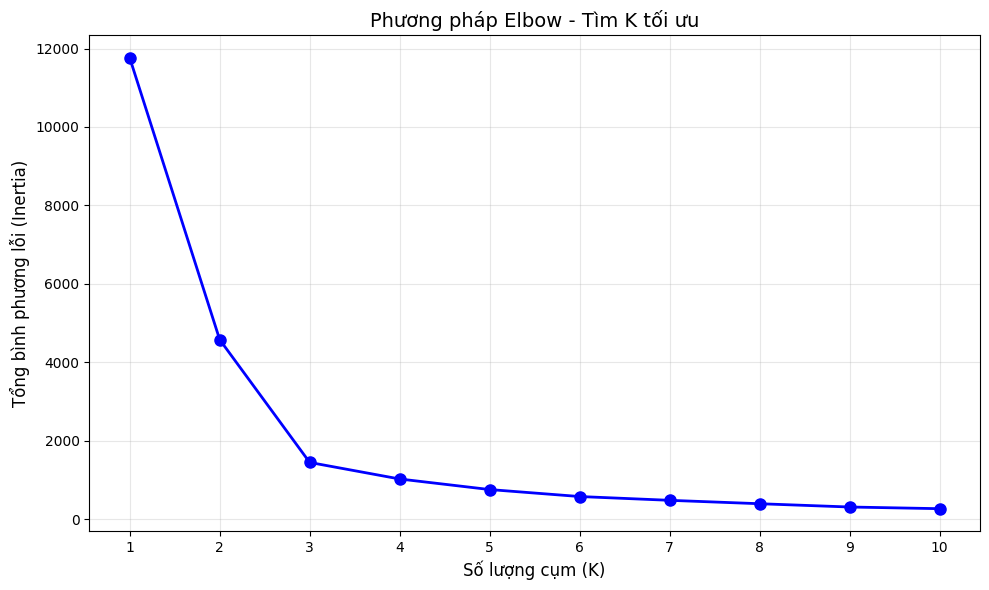


💡 Nhìn vào biểu đồ, chọn K tại điểm 'khuỷu tay' - nơi đường cong bắt đầu phẳng.


In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Phương pháp Elbow: Chọn giá trị k tốt nhất
sse = []  # Sum of Squared Errors (Inertia)
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)
    print(f"K = {k}: Inertia = {kmeans.inertia_:,.2f}")

# Vẽ biểu đồ Elbow
plt.figure(figsize=(10, 6))
plt.plot(K_range, sse, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Số lượng cụm (K)', fontsize=12)
plt.ylabel('Tổng bình phương lỗi (Inertia)', fontsize=12)
plt.title('Phương pháp Elbow - Tìm K tối ưu', fontsize=14)
plt.xticks(K_range)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../data/processed/elbow_plot.png', dpi=150)
plt.show()

print("\n💡 Nhìn vào biểu đồ, chọn K tại điểm 'khuỷu tay' - nơi đường cong bắt đầu phẳng.")

# Bước 5: Đánh giá bằng Silhouette Score

K = 2: Silhouette Score = 0.9862
K = 3: Silhouette Score = 0.6889
K = 4: Silhouette Score = 0.5909
K = 5: Silhouette Score = 0.6077
K = 6: Silhouette Score = 0.4951
K = 7: Silhouette Score = 0.5080
K = 8: Silhouette Score = 0.5085
K = 9: Silhouette Score = 0.5073
K = 10: Silhouette Score = 0.4924

🏆 K tốt nhất: 2 với Silhouette Score = 0.9862


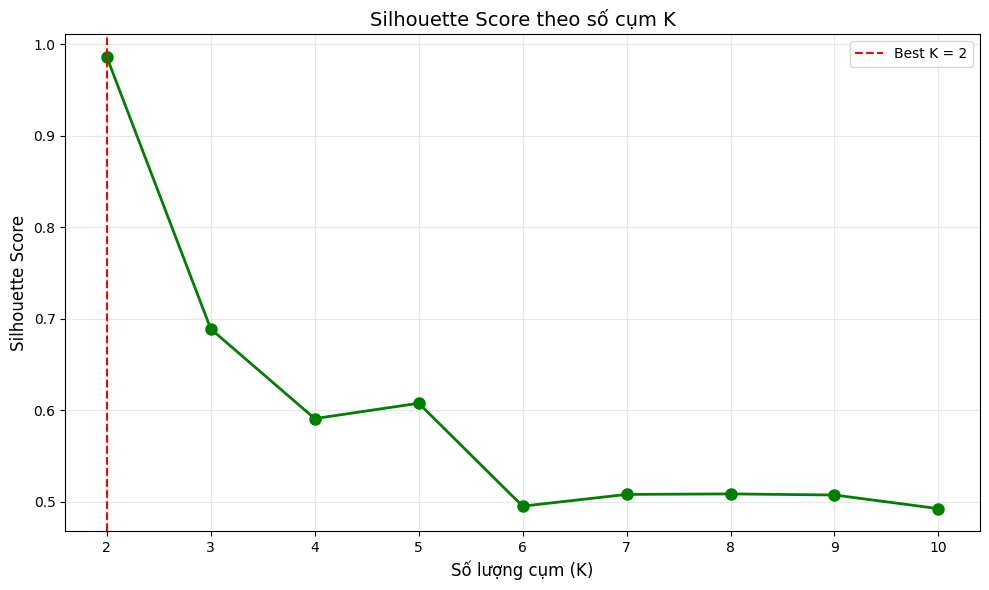

In [5]:
from sklearn.metrics import silhouette_score

# Tính Silhouette Score cho mỗi K
silhouette_scores = []
K_range_sil = range(2, 11)  # Silhouette cần ít nhất 2 cluster

for k in K_range_sil:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"K = {k}: Silhouette Score = {score:.4f}")

# Tìm K tốt nhất
best_k = list(K_range_sil)[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
print(f"\n🏆 K tốt nhất: {best_k} với Silhouette Score = {best_score:.4f}")

# Vẽ biểu đồ Silhouette
plt.figure(figsize=(10, 6))
plt.plot(K_range_sil, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best K = {best_k}')
plt.xlabel('Số lượng cụm (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score theo số cụm K', fontsize=14)
plt.xticks(K_range_sil)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../data/processed/silhouette_rfm_plot.png', dpi=150)
plt.show()

# Bước 6: Khởi tạo và huấn luyện mô hình K-Means

In [6]:
# Chọn số cụm (có thể thay đổi dựa trên kết quả Elbow và Silhouette)
n_clusters = 4  # Thường K=3-5 là hợp lý cho RFM

# Khai báo mô hình KMeans
kmeans = KMeans(
    n_clusters=n_clusters, 
    init='k-means++',  # Khởi tạo thông minh hơn 'random'
    max_iter=300,
    n_init=10,
    random_state=42
)

# Huấn luyện mô hình
kmeans.fit(X_scaled)

# Lấy nhãn cluster và tâm cụm
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

print("=" * 50)
print(f"KẾT QUẢ HUẤN LUYỆN K-MEANS (K={n_clusters})")
print("=" * 50)
print(f"\nInertia (SSE): {kmeans.inertia_:,.2f}")
print(f"Số iteration: {kmeans.n_iter_}")

print("\n" + "=" * 50)
print("TÂM CỤM (CENTROIDS) - Đã chuẩn hóa")
print("=" * 50)
centroids_df = pd.DataFrame(
    centroids, 
    columns=['Recency', 'Frequency', 'Monetary'],
    index=[f'Cluster {i}' for i in range(n_clusters)]
)
print(centroids_df)

# Chuyển đổi tâm cụm về giá trị gốc
print("\n" + "=" * 50)
print("TÂM CỤM (CENTROIDS) - Giá trị gốc")
print("=" * 50)
centroids_original = scaler.inverse_transform(centroids)
centroids_original_df = pd.DataFrame(
    centroids_original, 
    columns=['Recency (ngày)', 'Frequency (đơn)', 'Monetary (£)'],
    index=[f'Cluster {i}' for i in range(n_clusters)]
)
print(centroids_original_df.round(2))

KẾT QUẢ HUẤN LUYỆN K-MEANS (K=4)

Inertia (SSE): 1,022.35
Số iteration: 19

TÂM CỤM (CENTROIDS) - Đã chuẩn hóa
            Recency  Frequency   Monetary
Cluster 0  2.024425  -0.140389  -0.059951
Cluster 1  0.616409  -0.102686  -0.054558
Cluster 2 -0.916258  59.468493  60.396787
Cluster 3 -0.605377   0.036283   0.005167

TÂM CỤM (CENTROIDS) - Giá trị gốc
           Recency (ngày)  Frequency (đơn)  Monetary (£)
Cluster 0          293.65             1.37        599.90
Cluster 1          153.53             2.23        752.98
Cluster 2            1.00          1373.00    1716830.53
Cluster 3           31.94             5.43       2448.45


# Bước 7: Đo lường hiệu năng mô hình

In [7]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Tính các metrics đánh giá
sil_score = silhouette_score(X_scaled, labels)
db_score = davies_bouldin_score(X_scaled, labels)
ch_score = calinski_harabasz_score(X_scaled, labels)

print("=" * 50)
print("ĐÁNH GIÁ CHẤT LƯỢNG PHÂN CỤM")
print("=" * 50)
print(f"\n📊 Silhouette Score: {sil_score:.4f}")
print("   (Càng gần 1 càng tốt, > 0.5 là khá tốt)")

print(f"\n📊 Davies-Bouldin Index: {db_score:.4f}")
print("   (Càng gần 0 càng tốt)")

print(f"\n📊 Calinski-Harabasz Index: {ch_score:,.2f}")
print("   (Càng cao càng tốt)")

print(f"\n📊 Inertia (Within-cluster SSE): {kmeans.inertia_:,.2f}")
print("   (Càng thấp càng tốt cho cùng K)")

ĐÁNH GIÁ CHẤT LƯỢNG PHÂN CỤM

📊 Silhouette Score: 0.5909
   (Càng gần 1 càng tốt, > 0.5 là khá tốt)

📊 Davies-Bouldin Index: 0.4129
   (Càng gần 0 càng tốt)

📊 Calinski-Harabasz Index: 13,717.26
   (Càng cao càng tốt)

📊 Inertia (Within-cluster SSE): 1,022.35
   (Càng thấp càng tốt cho cùng K)


# Bước 8: Phân tích đặc điểm từng cụm khách hàng

In [8]:
# Gán nhãn cluster vào bảng RFM
rfm['Cluster'] = labels

# Thống kê theo từng cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)

cluster_summary.columns = ['Số KH', 'Recency TB (ngày)', 'Frequency TB (đơn)', 'Monetary TB (£)']
cluster_summary['% Tổng'] = (cluster_summary['Số KH'] / cluster_summary['Số KH'].sum() * 100).round(1)

print("=" * 70)
print("THỐNG KÊ TỪNG CLUSTER")
print("=" * 70)
print(cluster_summary)

# Đặt tên cho từng cluster dựa trên đặc điểm RFM
print("\n" + "=" * 70)
print("PHÂN LOẠI KHÁCH HÀNG")
print("=" * 70)

for cluster_id in range(n_clusters):
    row = cluster_summary.loc[cluster_id]
    r, f, m = row['Recency TB (ngày)'], row['Frequency TB (đơn)'], row['Monetary TB (£)']
    count = int(row['Số KH'])
    pct = row['% Tổng']
    
    # Phân loại dựa trên RFM
    if r < 50 and f > 10 and m > 5000:
        name = "💎 VIP Champions"
        desc = "Khách hàng VIP, mua thường xuyên, chi tiêu cao"
    elif r < 100 and f > 5:
        name = "⭐ Loyal Customers"
        desc = "Khách hàng trung thành, mua đều đặn"
    elif r > 200:
        name = "💀 Lost/Churned"
        desc = "Khách hàng đã rời bỏ, cần win-back"
    elif f <= 2:
        name = "🆕 New/Casual"
        desc = "Khách hàng mới hoặc thỉnh thoảng mua"
    else:
        name = "👤 Regular"
        desc = "Khách hàng bình thường"
    
    print(f"\nCluster {cluster_id}: {name}")
    print(f"   📊 {count:,} khách hàng ({pct}%)")
    print(f"   📅 Recency: {r:.0f} ngày | Frequency: {f:.1f} đơn | Monetary: £{m:,.0f}")
    print(f"   💡 {desc}")

THỐNG KÊ TỪNG CLUSTER
         Số KH  Recency TB (ngày)  Frequency TB (đơn)  Monetary TB (£)  % Tổng
Cluster                                                                       
0          558             293.65                1.37           599.90    14.2
1          738             153.86                2.23           752.59    18.8
2            1               1.00             1373.00       1716830.53     0.0
3         2624              32.03                5.43          2445.97    66.9

PHÂN LOẠI KHÁCH HÀNG

Cluster 0: 💀 Lost/Churned
   📊 558 khách hàng (14.2%)
   📅 Recency: 294 ngày | Frequency: 1.4 đơn | Monetary: £600
   💡 Khách hàng đã rời bỏ, cần win-back

Cluster 1: 👤 Regular
   📊 738 khách hàng (18.8%)
   📅 Recency: 154 ngày | Frequency: 2.2 đơn | Monetary: £753
   💡 Khách hàng bình thường

Cluster 2: 💎 VIP Champions
   📊 1 khách hàng (0.0%)
   📅 Recency: 1 ngày | Frequency: 1373.0 đơn | Monetary: £1,716,831
   💡 Khách hàng VIP, mua thường xuyên, chi tiêu cao

Cluster 3: ⭐ 

# Bước 9: Trực quan hóa các cụm

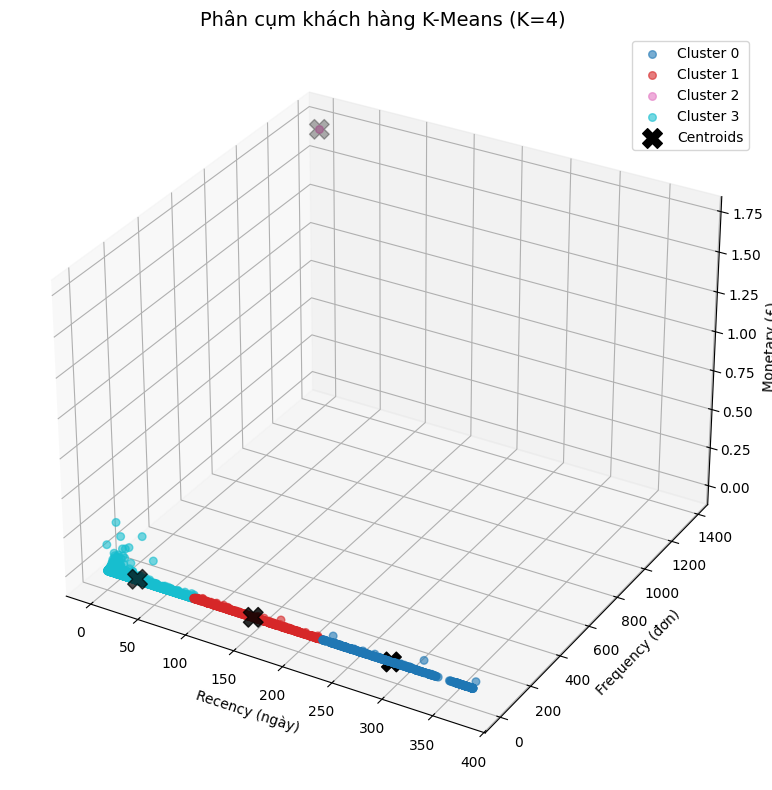

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Vẽ biểu đồ 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Lấy màu cho mỗi cluster
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

for i in range(n_clusters):
    mask = labels == i
    ax.scatter(
        rfm.loc[mask, 'Recency'],
        rfm.loc[mask, 'Frequency'],
        rfm.loc[mask, 'Monetary'],
        c=[colors[i]],
        label=f'Cluster {i}',
        alpha=0.6,
        s=30
    )

# Vẽ tâm cụm
ax.scatter(
    centroids_original[:, 0],
    centroids_original[:, 1],
    centroids_original[:, 2],
    c='black',
    marker='X',
    s=200,
    label='Centroids'
)

ax.set_xlabel('Recency (ngày)')
ax.set_ylabel('Frequency (đơn)')
ax.set_zlabel('Monetary (£)')
ax.set_title(f'Phân cụm khách hàng K-Means (K={n_clusters})', fontsize=14)
ax.legend()
plt.tight_layout()
plt.savefig('../data/processed/kmeans_3d_plot.png', dpi=150)
plt.show()

In [ ]:
# Vẽ biểu đồ 2D (các cặp đặc trưng)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

pairs = [
    ('Recency', 'Frequency'),
    ('Recency', 'Monetary'),
    ('Frequency', 'Monetary')
]

for ax, (x_col, y_col) in zip(axes, pairs):
    for i in range(n_clusters):
        mask = labels == i
        ax.scatter(
            rfm.loc[mask, x_col],
            rfm.loc[mask, y_col],
            c=[colors[i]],
            label=f'Cluster {i}',
            alpha=0.6,
            s=20
        )
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f'{x_col} vs {y_col}')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/kmeans_2d_plots.png', dpi=150)
plt.show()

# Bước 10: Dự đoán nhóm cho khách hàng mới

In [10]:
# Ví dụ: Dự đoán cụm cho một khách hàng mới
# Khách hàng mới với RFM: Recency=30 ngày, Frequency=5 đơn, Monetary=£2000

new_customer = np.array([[30, 5, 2000]])  # [Recency, Frequency, Monetary]

# Chuẩn hóa dữ liệu mới (dùng scaler đã fit trước đó)
new_customer_scaled = scaler.transform(new_customer)

# Dự đoán cluster
predicted_cluster = kmeans.predict(new_customer_scaled)

print("=" * 50)
print("DỰ ĐOÁN CHO KHÁCH HÀNG MỚI")
print("=" * 50)
print(f"\n📊 Thông tin khách hàng:")
print(f"   - Recency: {new_customer[0][0]} ngày (mua cách đây {new_customer[0][0]} ngày)")
print(f"   - Frequency: {new_customer[0][1]} đơn hàng")
print(f"   - Monetary: £{new_customer[0][2]:,}")
print(f"\n🎯 Kết quả: Khách hàng thuộc Cluster {predicted_cluster[0]}")

DỰ ĐOÁN CHO KHÁCH HÀNG MỚI

📊 Thông tin khách hàng:
   - Recency: 30 ngày (mua cách đây 30 ngày)
   - Frequency: 5 đơn hàng
   - Monetary: £2,000

🎯 Kết quả: Khách hàng thuộc Cluster 3


In [ ]:
# Nhập thông tin khách hàng mới từ bàn phím
print("=" * 50)
print("NHẬP THÔNG TIN KHÁCH HÀNG MỚI")
print("=" * 50)

try:
    recency = float(input("Nhập Recency (số ngày từ lần mua cuối): "))
    frequency = float(input("Nhập Frequency (số đơn hàng): "))
    monetary = float(input("Nhập Monetary (tổng tiền đã chi, £): "))
    
    # Tạo điểm dữ liệu mới
    new_sample = np.array([[recency, frequency, monetary]])
    
    # Chuẩn hóa
    new_sample_scaled = scaler.transform(new_sample)
    
    # Dự đoán
    predicted = kmeans.predict(new_sample_scaled)
    
    print(f"\n" + "=" * 50)
    print("KẾT QUẢ DỰ ĐOÁN")
    print("=" * 50)
    print(f"\n📊 Điểm dữ liệu: Recency={recency}, Frequency={frequency}, Monetary=£{monetary:,}")
    print(f"\n🎯 Phân cụm: Cluster {predicted[0]}")
    
    # So sánh với centroid của cluster
    cluster_centroid = centroids_original[predicted[0]]
    print(f"\n📍 Tâm cụm {predicted[0]}:")
    print(f"   - Recency TB: {cluster_centroid[0]:.0f} ngày")
    print(f"   - Frequency TB: {cluster_centroid[1]:.1f} đơn")
    print(f"   - Monetary TB: £{cluster_centroid[2]:,.0f}")
    
except ValueError:
    print("❌ Lỗi: Vui lòng nhập số hợp lệ!")

# Bước 11: Lưu kết quả

In [ ]:
# Lưu bảng RFM với nhãn cluster
rfm.to_csv('../data/processed/rfm_with_clusters.csv', index=False)
print("✅ Đã lưu: rfm_with_clusters.csv")

# Lưu thống kê cluster
cluster_summary.to_csv('../data/processed/cluster_summary_rfm.csv')
print("✅ Đã lưu: cluster_summary_rfm.csv")

# Lưu model (nếu cần)
import joblib
joblib.dump(kmeans, '../data/processed/kmeans_model.pkl')
joblib.dump(scaler, '../data/processed/scaler.pkl')
print("✅ Đã lưu: kmeans_model.pkl và scaler.pkl")

print("\n" + "=" * 50)
print("HOÀN THÀNH!")
print("=" * 50)